In [1]:
import numpy as np
import notebooks.src.visualizingrestatements.visualizingrestatements as vs
import datetime as dt
import pandas as pd
import time
import sys
import os
from contextlib import contextmanager
from io import StringIO
from collections import defaultdict
from botocore.config import Config
from stations.station import df_from_s3_csv, df_to_s3_csv
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from math import ceil
import boto3
import re
import notebooks.src.metrics_timeseries.metrics_timeseries as mts
from collections import OrderedDict
from scipy.stats import sem
import notebooks.src.metrics.metrics as m

In [2]:
ACCESS_KEY_ID = # add yours here
SECRET_ACCESS_KEY = # add yours here
creds_dict = {
    'aws_access_key_id': ACCESS_KEY_ID,
    'aws_secret_access_key': SECRET_ACCESS_KEY,
    'region_name': "us-west-2",
    'config': Config(s3={"use_accelerate_endpoint": True})
}

In [3]:
client = boto3.client('s3')
result = client.list_objects(Bucket='us-formatted-data', Prefix='JHU/US/', Delimiter='/')
vals =  [ res.get('Prefix') for res in result.get('CommonPrefixes') ]

In [4]:
states = ["Alabama",
"Alaska",
"Arizona",
"Arkansas",
"California",
"Colorado",
"Connecticut",
"Delaware",
"Florida",
"Georgia",
"Hawaii",
"Idaho",
"Illinois",
"Indiana",
"Iowa",
"Kansas",
"Kentucky",
"Louisiana",
"Maine",
"Maryland",
"Massachusetts",
"Michigan",
"Minnesota",
"Mississippi",
"Missouri",
"Montana",
"Nebraska",
"Nevada",
"New Hampshire",
"New Jersey",
"New Mexico",
"New York",
"North Carolina",
"North Dakota",
"Ohio",
"Oklahoma",
"Oregon",
"Pennsylvania",
"Rhode Island",
"South Carolina",
"South Dakota",
"Tennessee",
"Texas",
"Utah",
"Vermont",
"Virginia",
"Washington",
"West Virginia",
"Wisconsin",
"Wyoming"]

In [5]:
state_buckets = [state for state in vals if state.replace("JHU/US/", "").replace("/", "") in states ]

In [6]:
start, stop = '2020-02-14','2022-06-11'
COL = "deaths"
REGION = "California"
data_title = f'JHU {REGION} {COL.title()}'

def get_df(state, col):

    dates = pd.date_range(start=start, end=stop)
    df = df_from_s3_csv(bucket='us-formatted-data', key=f'JHU/US/{state}//{col}/data.csv', **creds_dict)
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
    df.columns = pd.to_datetime(df.columns, format="%Y-%m-%d")
    adj_df = pd.DataFrame(columns=dates, index=dates)
    adj_df.update(df)

    return adj_df.diff(axis=0)


In [7]:
dfs_dict = {
    state :
    get_df(state = state, col = COL)
    for state in states[4:5]
}
arrays_dict  = {key: df.to_numpy( na_value=np.nan) for key, df in dfs_dict.items()}

Attempting to read S3 object JHU/US/California//deaths/data.csv in us-formatted-data
Successfully read S3 object JHU/US/California//deaths/data.csv in us-formatted-data


In [8]:
df = dfs_dict[REGION]
X = df.to_numpy( na_value = np.nan)

In [9]:
path = '../latex/plots/metrics/JHU_{region}_{metric}_surge.png'

In [10]:
restatement_dct = m.major_restatements_all(X, df.index)
restatement_df = pd.DataFrame(restatement_dct).T
mrs = restatement_df[restatement_df['major_restatement']].index
mrs

DatetimeIndex(['2021-01-19', '2021-04-13', '2021-04-19', '2021-06-11',
               '2021-07-07', '2021-10-19', '2022-05-09'],
              dtype='datetime64[ns]', freq=None)

# Accuracy

In [11]:
def measure_all_accuracy(releases, offsets):

    vals = []
    
    for release_num in range( 1, releases.shape[1] ) :
        row = [] #release_num]

        for offset in offsets:
            if offset + release_num < releases.shape[1]:
                row.append(mts.measure_accuracy(X[: release_num, release_num], X[:release_num, release_num+offset], release_num))
            else:
                row.append(np.nan)

        row.append(mts.measure_accuracy(X[: release_num, release_num], X[:release_num, -1], release_num))
        
        vals.append(row)

    return np.array(vals)

In [12]:
offsets = [30, 90, 150, 365] 
measured_accuracy = measure_all_accuracy(X, offsets)

In [13]:
columns = [f'{offset}' for offset in offsets] + ['latest release']
accuracy_df = pd.DataFrame(measured_accuracy, index=df.index[1: ], columns=columns)

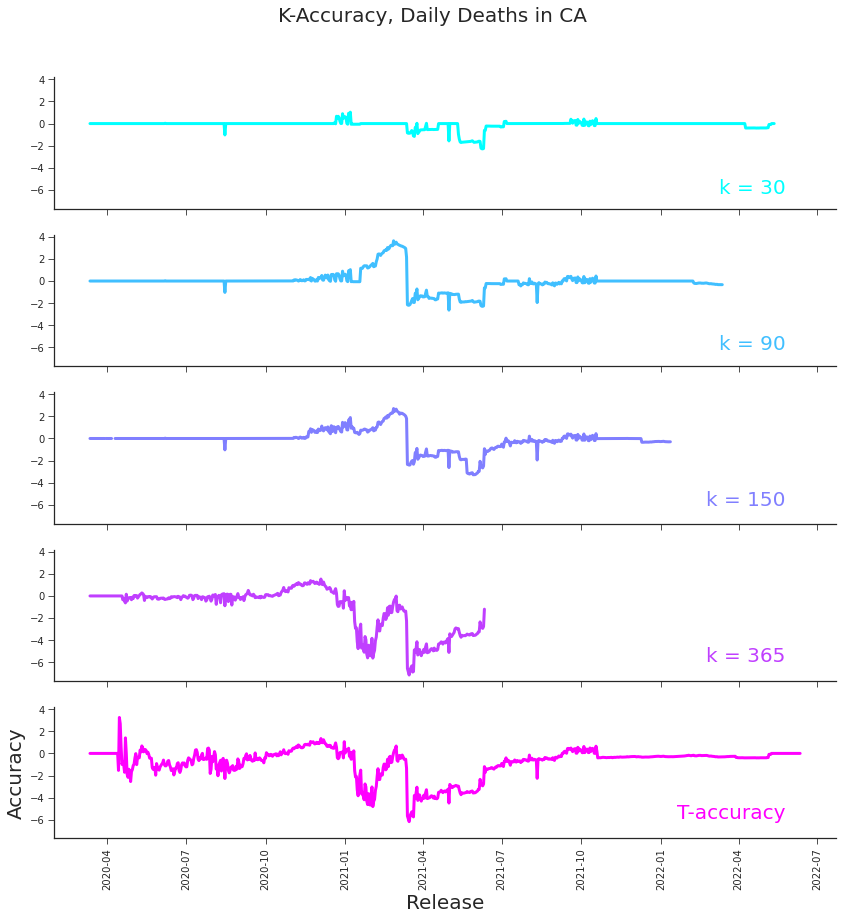

In [14]:
title = "AK-Accuracy" + "\n" + data_title
x_label = "Release"
y_label = "Accuracy"

plt, axs, setup_dct =  vs.setup_plot(
    accuracy_df, "", "", x_label, y_label,
    nrows=accuracy_df.shape[1], ncols=1, y_scale="linear", figsize=(14,14)
)

colors = plt.cm.cool(np.linspace(0, 1, len(accuracy_df.columns)))

for i, col in enumerate(accuracy_df.columns):
    axs[i, 0].plot( accuracy_df[col], color=colors[i])

    if i == 4:
        plt.gcf().text(0.85, 0.765 - .155*i, f'T-accuracy',
            horizontalalignment='right',
            color=colors[i], fontsize=20)
    else: 
        plt.gcf().text(0.85, 0.765 - .155*i, f'k = {col}',
            horizontalalignment='right',
            color=colors[i], fontsize=20)

plt.suptitle("K-Accuracy, Daily Deaths in CA", fontsize=20, y=.95)
plt.savefig(path.format(region=REGION, metric='accuracy'),  bbox_inches="tight")

In [15]:
def get_accuracy(list_of_states):
    adf_dict = {}
    for state in list_of_states:
        X = arrays_dict[state]
        acc = measure_all_accuracy(X, offsets)

        columns = [f'{offset}' for offset in offsets] + ['latest release']
        accuracy_df = pd.DataFrame(measured_accuracy, index=df.index[1: ], columns=columns)
        adf_dict[state] = accuracy_df

    return adf_dict

In [16]:
acc_dct = get_accuracy(arrays_dict.keys())

In [17]:
def all_major_restatements(releases, release_dates, **kwargs):

    mrs = []
    mrs_dates = []

    for i in range(1, releases.shape[1]):
        if mts.major_restatement(releases[:, i], i, releases[:, i-1], **kwargs):
            mrs.append(i)
            mrs_dates.append(release_dates[i])

    return mrs_dates

In [18]:
all_major_restatements(X, df.index)

[Timestamp('2021-04-19 00:00:00', freq='D'),
 Timestamp('2021-07-07 00:00:00', freq='D'),
 Timestamp('2021-10-19 00:00:00', freq='D'),
 Timestamp('2022-05-09 00:00:00', freq='D')]

In [19]:
def accuracy_mr_impact_plots(region, **kwargs):

    accuracy_df = acc_dct[region]
    X = arrays_dict[region]
    accuracy_estimates = m.accuracy_estimates_all(accuracy_df.iloc[:, :-1], accuracy_df.index)
    mrs = all_major_restatements(X, df.index, **kwargs)

    title = "Performance of Accuracy Estimates"
    x_label = "Release"
    y_label = "Accuracy"

    plt, axs, setup_dct =  vs.setup_plot(
        accuracy_estimates, title, data_title, x_label, y_label,
        nrows=accuracy_estimates.shape[1], ncols=1, y_scale="linear", figsize=(14,10)
    )
    
    colors = plt.cm.cool(np.linspace(0, 1, accuracy_estimates.shape[1]))
    colors_mr = plt.cm.hsv(np.linspace(0, 1, len(mrs) + 2))
    releases = accuracy_estimates.index.to_list()


    for i, col in enumerate(accuracy_estimates.columns):

        for j, mr in enumerate(mrs):

            ind_loc = releases.index(mr)
            ind_lhs = max(0, ind_loc - int(col))
            lhs = releases[ind_lhs]

            sky = j
            if sky > 0:
                sky += 1 
            axs[i, 0].plot( [lhs, mr], [-5 + .0015 , -5+ .0015], color=colors_mr[sky], alpha=0.4)
            axs[i, 0].plot( [lhs, mr], [2.5 + .0015 , 2.5+ .0015], color=colors_mr[sky], alpha=0.4)
            axs[i, 0].plot( [lhs, lhs], [-5 + .0015 , 2.5+ .0015], color=colors_mr[sky], alpha=0.4)        
            axs[i, 0].plot( [mr, mr], [-5 + .0015 , 2.5+ .0015], color=colors_mr[sky], alpha=0.4)

        c = colors[i]
        axs[i, 0].plot( accuracy_df[col], color='grey')#c)
        # axs[i, 0].plot( accuracy_estimates[col], color='orangered')

        plt.gcf().text(0.15, 0.725 - .195*i, f'k = {col}',
            horizontalalignment='left',
            color='grey',# colors[i],
            fontsize=20)

    for j, mr in enumerate(mrs):

        sky = j
        if sky> 0:
            sky += 1 
        plt.gcf().text(0.32 + .1*j, 0.9, mr.strftime('%Y-%m-%d'),
            horizontalalignment='right',
            color=colors_mr[sky], fontsize=15)
        
        if j > 5:
            break
    
    
    plt.suptitle(f'Impact Window of Major Restatements on Accuracy of Release\nDaily Deaths in CA', fontsize=20)
    plt.savefig(path.format(region=region, metric='accuracy_mr_impact'),  bbox_inches="tight")



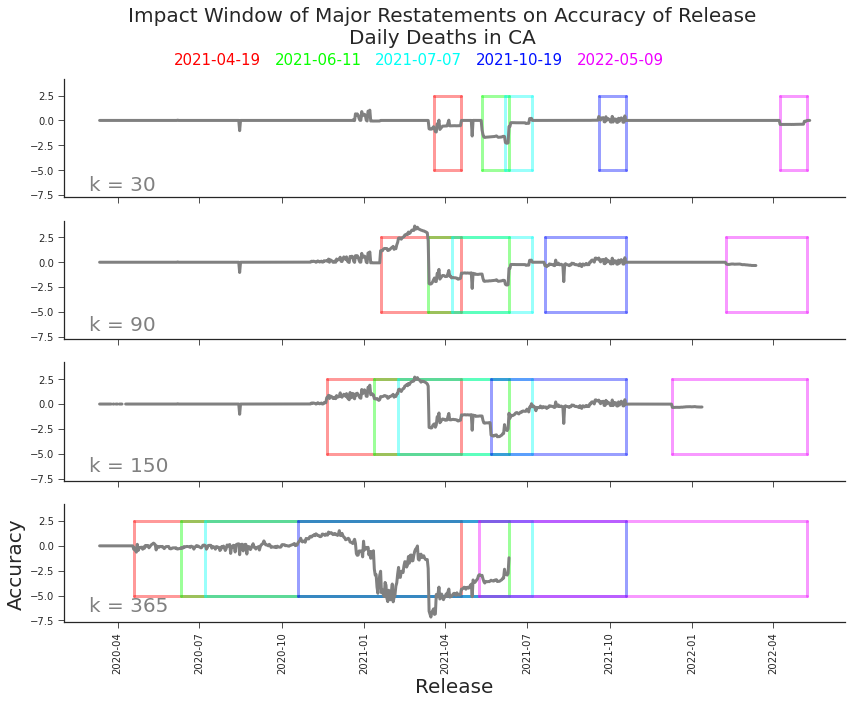

In [20]:
mr_alpha=2
beta=.2
accuracy_mr_impact_plots("California", alpha=mr_alpha, beta=beta)

In [21]:
def assess_all_accuracy(releases, offsets, func):

    vals = []
    
    for release_num in range( 1, releases.shape[1] ) :
        row = []


        for offset in offsets:
            if offset + release_num < releases.shape[1]:
                row.append(func(X[: release_num, :release_num], offset))
            else:
                row.append(np.nan)

        vals.append(row)

    return np.array(vals)

In [22]:
assessed_X = assess_all_accuracy(X, offsets, mts.assess_accuracy_release_history )

In [23]:
measured_acc_rh_X = assess_all_accuracy(X, offsets, mts.measure_accuracy_release_history )

In [24]:
columns = [f'{offset}' for offset in offsets]
assessed_df = pd.DataFrame(assessed_X, index=df.index[1: ], columns=columns)
accuracy_rh_df = pd.DataFrame(measured_acc_rh_X, index=df.index[1: ], columns=columns)

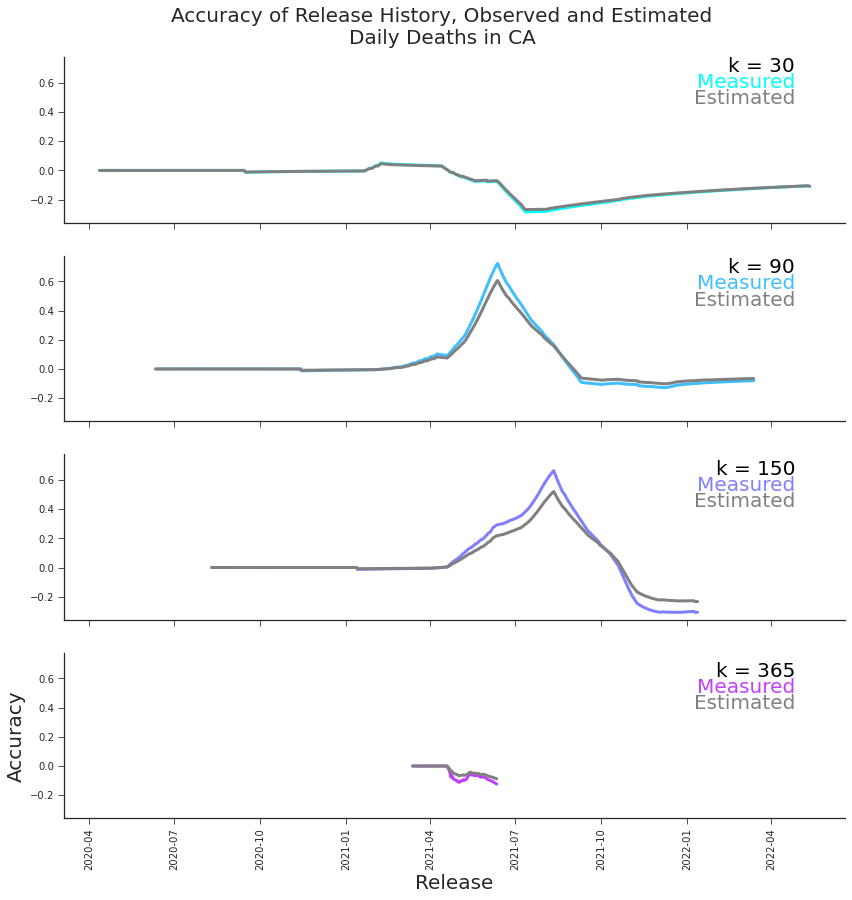

In [25]:
title = "(Surge) Accuracy of Release History, Measured and Estimated" + "\n" + data_title
x_label = "Release"
y_label = "Accuracy"

plt, axs, setup_dct =  vs.setup_plot(
    assessed_df, "", "", x_label, y_label,
    nrows=assessed_df.shape[1], ncols=1, y_scale="linear", figsize=(14,14)
)

colors = plt.cm.cool(np.linspace(0, 1, len(accuracy_df.columns)))

for i, col in enumerate(assessed_df.columns):
    axs[i, 0].plot( accuracy_rh_df[col], color=colors[i])
    axs[i, 0].plot( assessed_df[col], color="grey")

    plt.gcf().text(0.85, 0.866 - .2*i, f'k = {col}',
        horizontalalignment='right',
        color="black", fontsize=20)
    plt.gcf().text(0.85, 0.85 - .2*i, f'Measured',
        horizontalalignment='right',
        color=colors[i], fontsize=20)
    plt.gcf().text(0.85, 0.834 - .2*i, f'Estimated',
        horizontalalignment='right',
        color="grey", fontsize=20)

plt.suptitle("Accuracy of Release History, Observed and Estimated\nDaily Deaths in CA", fontsize=20, y=.93)
plt.savefig(path.format(region=REGION, metric='accuracy_rh'),  bbox_inches="tight")

In [26]:
def accuracy_hr_impact_plots(region, **kwargs):

    accuracy_df = acc_dct[region]
    X = arrays_dict[region]
    accuracy_estimates = m.accuracy_estimates_all(accuracy_df.iloc[:, :-1], accuracy_df.index)
    mrs = all_major_restatements(X, df.index, **kwargs)

    title = "Performance of Accuracy Estimates"
    x_label = "Release"
    y_label = "Accuracy"

    plt, axs, setup_dct =  vs.setup_plot(
        accuracy_estimates, title, data_title, x_label, y_label,
        nrows=accuracy_estimates.shape[1], ncols=1, y_scale="linear", figsize=(14,10)
    )
    
    colors_ = plt.cm.cool(np.linspace(0, 1, len(accuracy_df.columns)))
    colors = plt.cm.cool(np.linspace(0, 1, accuracy_estimates.shape[1]))
    colors_mr = plt.cm.hsv(np.linspace(0, 1, len(mrs) + 2))
    releases = accuracy_estimates.index.to_list()


    for i, col in enumerate(accuracy_estimates.columns):

        for j, mr in enumerate(mrs):

            ind_loc = releases.index(mr)
            ind_lhs = max(0, ind_loc - int(col))
            lhs = releases[ind_lhs]

            sky = j
            if sky > 0:
                sky += 1
            axs[i, 0].plot( [lhs, mr], [-.5 + .0015 , -.5+ .0015], color=colors_mr[sky], alpha=0.4)
            axs[i, 0].plot( [lhs, mr], [1 + .0015 , 1+ .0015], color=colors_mr[sky], alpha=0.4)
            axs[i, 0].plot( [lhs, lhs], [-.5 + .0015 , 1+ .0015], color=colors_mr[sky], alpha=0.4)        
            axs[i, 0].plot( [mr, mr], [-.5 + .0015 , 1+ .0015], color=colors_mr[sky], alpha=0.4)

        c = colors[i]
        axs[i, 0].plot( accuracy_rh_df[col], color=colors_[i])
        axs[i, 0].plot( assessed_df[col], color="grey")
        # axs[i, 0].plot( accuracy_estimates[col], color='orangered')

        plt.gcf().text(0.85, 0.86 - .2*i, f'k = {col}',
            horizontalalignment='right',
            color="black", fontsize=20, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))
        plt.gcf().text(0.85, 0.835 - .2*i, f'Measured',
            horizontalalignment='right',
            color=colors[i], fontsize=20, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))
        plt.gcf().text(0.85, 0.81 - .2*i, f'Estimated',
            horizontalalignment='right',
            color="grey", fontsize=20, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))

    for j, mr in enumerate(mrs):
        sky = j
        if sky > 0:
            sky += 1
        plt.gcf().text(0.32 + .1*j, 0.9, mr.strftime('%Y-%m-%d'),
            horizontalalignment='right',
            color=colors_mr[sky], fontsize=15)

        
        if j > 5:
            break
    
    
    plt.suptitle(f'Impact Window of Major Restatements on Accuracy of Release History\nDaily Deaths in CA', fontsize=20)
    plt.savefig(path.format(region=region, metric='accuracy_mr_impact_hr'),  bbox_inches="tight")



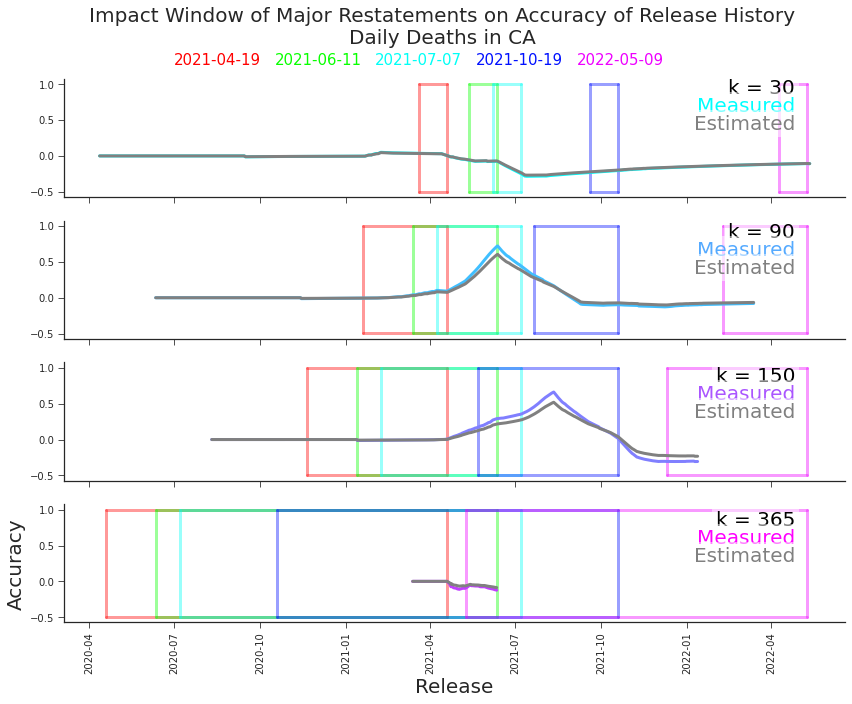

In [27]:
accuracy_hr_impact_plots("California", alpha=mr_alpha, beta=beta)

# Consistency

## Major Restatement

In [28]:
mrs = all_major_restatements(X, df.index, alpha=mr_alpha, beta=beta)

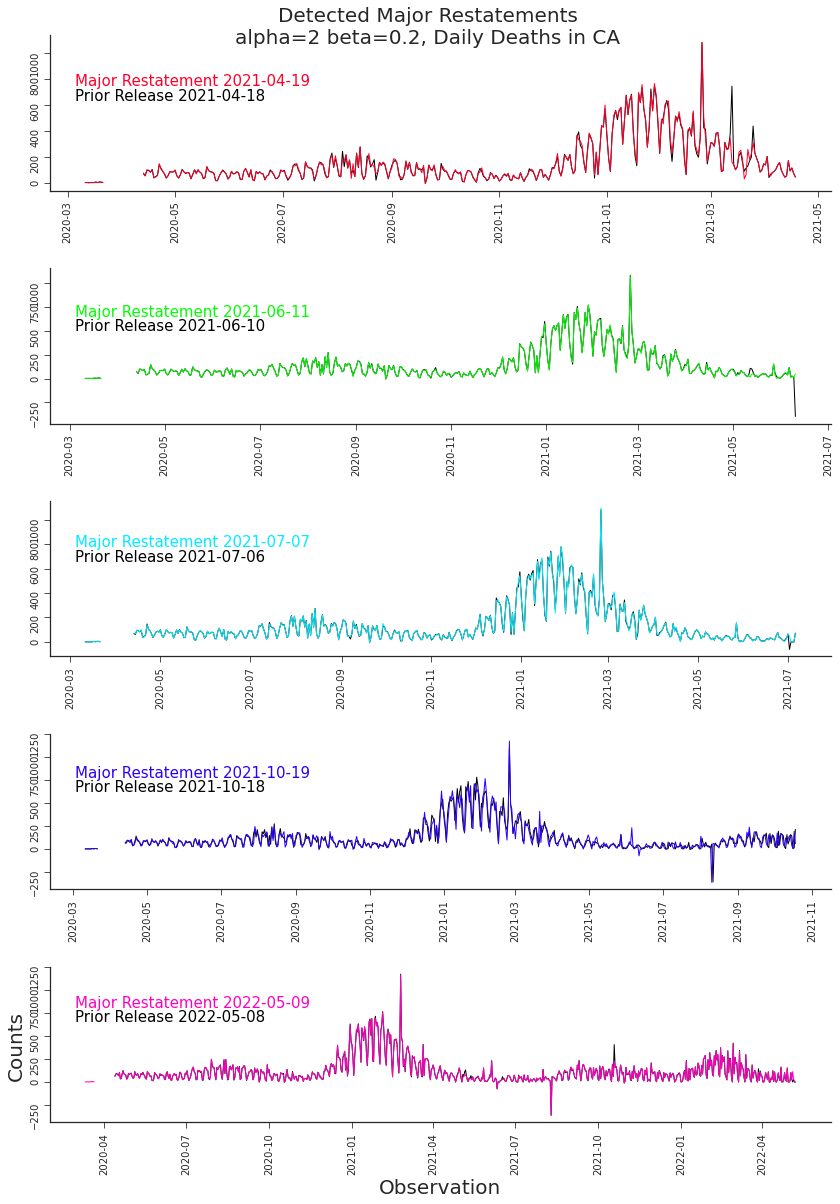

In [29]:
plt, axs, setup_dct =  vs.setup_plot(
    df, title="", data_title="", x_label="Observation", y_label="Counts",
    nrows=len(mrs), ncols=1, y_scale="linear", figsize=(14, 20), sharex=False, sharey=False
)
plt.suptitle(f'Detected Major Restatements\nalpha={mr_alpha} beta={beta}, Daily Deaths in CA', size=20, y=.9)

colors_mr = plt.cm.gist_rainbow(np.linspace(0, 1, len(mrs)+ 1))
releases = df.columns.tolist()
window=30

plt.subplots_adjust(hspace=.5)

for num, release in enumerate(mrs):
  
    i = releases.index(release)
    
    sky=num
    if sky > 0:
        sky += 1 
        
    axs[num, 0].plot(df.iloc[ : i , i -1], color="black", lw=1)
    axs[num, 0].plot(df.iloc[ : i , i], color=colors_mr[sky], lw=1)
    # axs[num, 0].plot(df.iloc[i-1: i + 2 ,i+1], color=colors_mr[num])
    axs[num, 0].tick_params(labelrotation=90)
    release = df.columns[i + 1].strftime('%Y-%m-%d')


    
    rel = df.columns[i].strftime('%Y-%m-%d')
    prev_rel = df.columns[i-1].strftime('%Y-%m-%d')
    plt.gcf().text(0.15, 0.845 - .16*num, f'Major Restatement {rel}',
        horizontalalignment='left',
        color=colors_mr[sky],
        fontsize=15)
    plt.gcf().text(0.15, 0.835 - .16*num, f'Prior Release {prev_rel}',
        horizontalalignment='left',
        color="black",
        fontsize=15)

plt.savefig(path.format(region=REGION, metric='mrs'),  bbox_inches="tight")

[Timestamp('2021-04-18 00:00:00', freq='D'), Timestamp('2021-04-19 00:00:00', freq='D'), Timestamp('2021-06-11 00:00:00', freq='D'), Timestamp('2021-07-07 00:00:00', freq='D'), Timestamp('2021-10-19 00:00:00', freq='D'), Timestamp('2022-05-09 00:00:00', freq='D')]


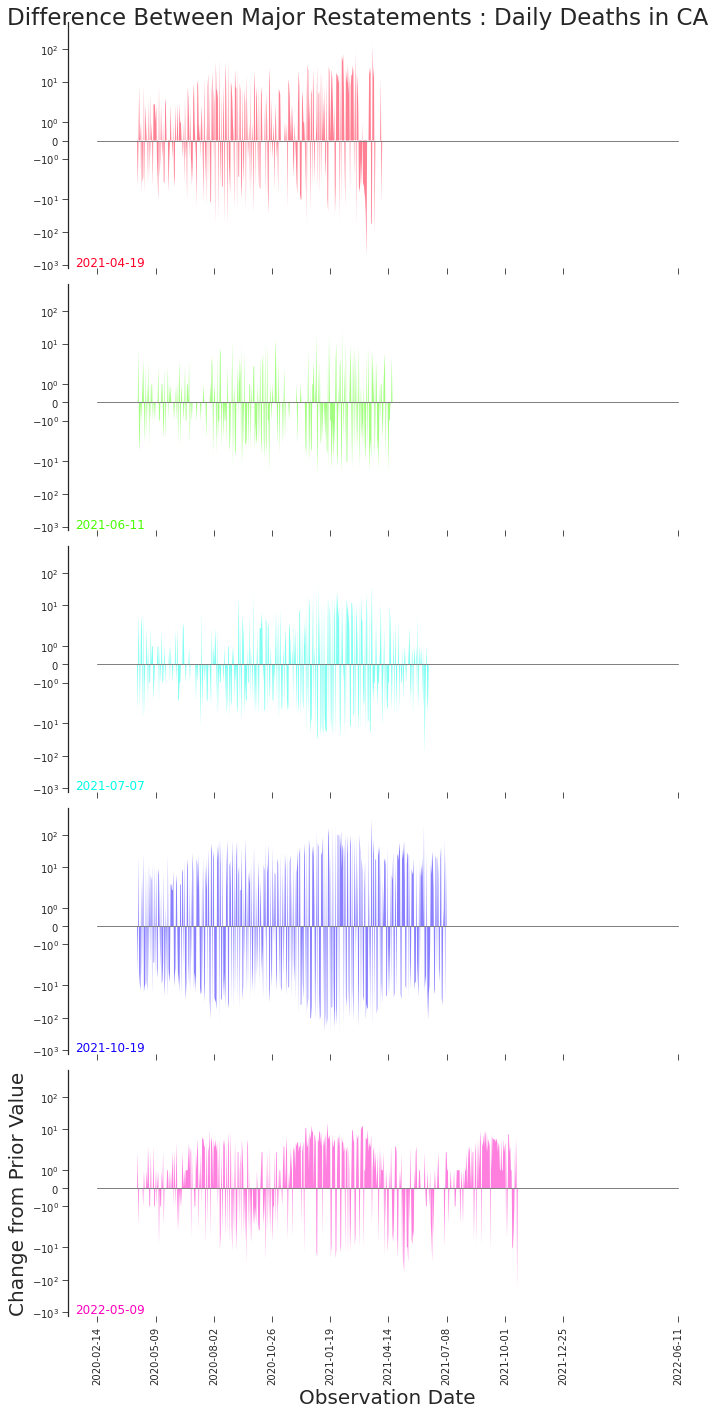

In [30]:
prior_to_first = df.columns.tolist().index(mrs[0]) - 1
temp = [df.columns[prior_to_first]] + mrs
print(temp)
plt, ax, _ = vs.plot_major_restatement_impacts(
    df.loc[:,temp], f'Daily Deaths in CA', save=False, min_per_changed=0, missing=True, small_multiples=True, percent=False,
    figsize=(10, 20), y_scale="symlog")

plt.suptitle(f'Difference Between Major Restatements\nDaily Deaths in CA')


plt.savefig(path.format(region=REGION, metric='mrs_diffs'),  bbox_inches="tight")

## NRC

In [31]:
# plot the 30 days before and after each in shared
window = 30
alpha= 4
shared = mts.shared_nrcs(X, window=window, alpha=alpha, neg=True)
nrcs = [(i, each) for i, each in enumerate(shared) if each ]
nonneg_shared = mts.shared_nrcs(X, window=window, alpha=alpha, neg=False)


In [32]:
nonneg_nrcs = [(i, each) for i, each in enumerate(nonneg_shared) if each ]


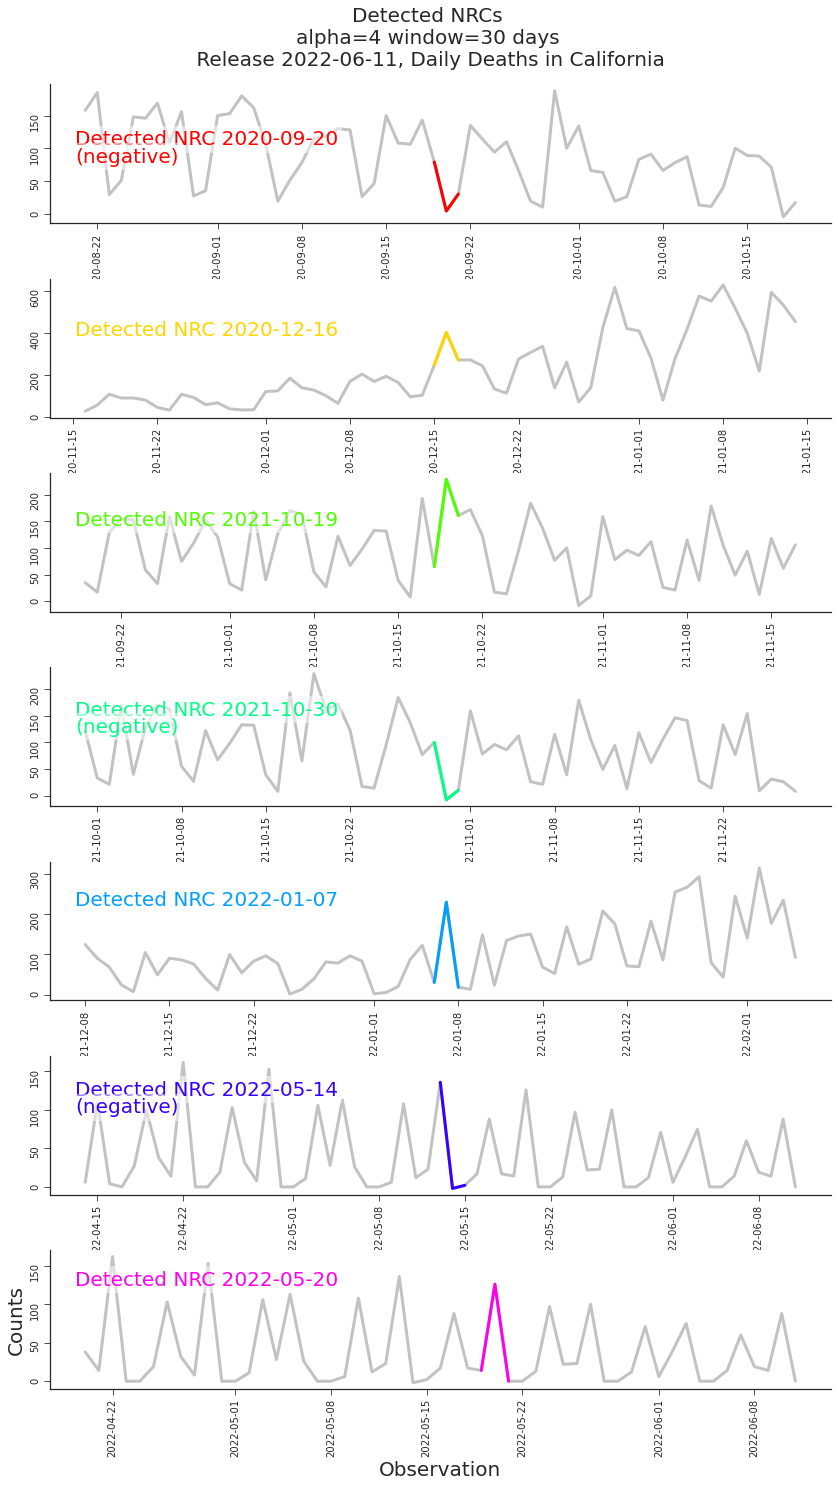

In [33]:
release = df.columns[-1].strftime('%Y-%m-%d')
plt, axs, setup_dct =  vs.setup_plot(
    df, title="", data_title="", x_label="Observation", y_label="Counts",
    nrows=len(nrcs), ncols=1, y_scale="linear", figsize=(14, 24), sharex=False, sharey=False
)
title = f'Detected NRCs\nalpha={alpha} window={window} days\n Release {release}, Daily Deaths in {REGION}'
plt.suptitle(title, size=20, y=.925)
plt.subplots_adjust(hspace=.4)
colors_nrc = plt.cm.hsv(np.linspace(0, 1, len(nrcs) + 1))

for num, pair in enumerate(nrcs):
    i, each = pair
  
    axs[num, 0].plot(df.iloc[i-window: i + window, -1], color="darkgrey", alpha=.7)
    axs[num, 0].plot(df.iloc[i-1: i + 2 ,-1], color=colors_nrc[num])
    axs[num, 0].tick_params(labelrotation=90)
    release = df.columns[i + 1].strftime('%Y-%m-%d')

    obsv = df.index[i].strftime('%Y-%m-%d')
    plt.gcf().text(0.15, 0.845 - .11*num, f'Detected NRC {obsv}',
        horizontalalignment='left',
        color=colors_nrc[num],
        fontsize=20, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))
    
    if pair not in nonneg_nrcs:
        plt.gcf().text(0.15, 0.835 - .11*num, f'(negative)',
            horizontalalignment='left',
            color=colors_nrc[num],
            fontsize=20, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))        


plt.savefig(path.format(region=REGION, metric='nrcs'),  bbox_inches="tight")

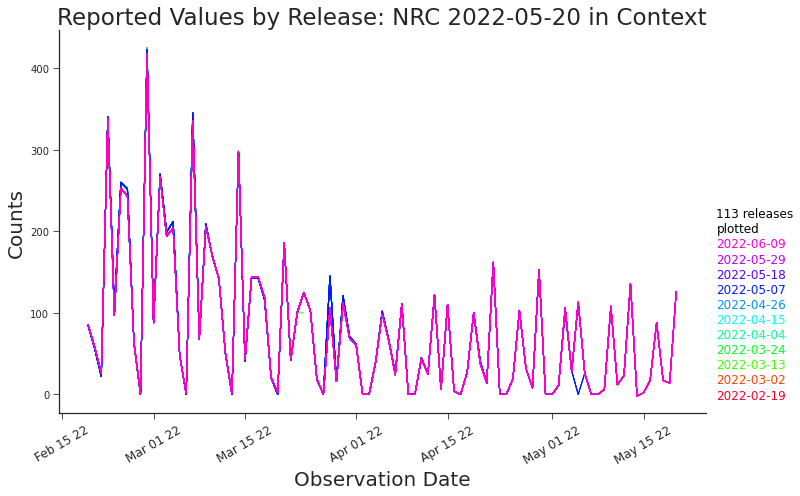

Text(0.5, 0.98, '')

In [34]:
i = nrcs[-1][0]
day = df.index[i].strftime('%Y-%m-%d')
plt, ax, _ = vs.plot_multiple_releases(
    df.iloc[i-3*window: i+1 , i-3*window: i + window],
    f'NRC {day} in Context', shift=0)
plt.suptitle("")

<AxesSubplot:>

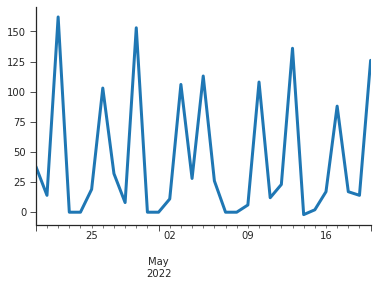

In [35]:
df.iloc[i-window: i+1 , i + 1].plot()

<AxesSubplot:>

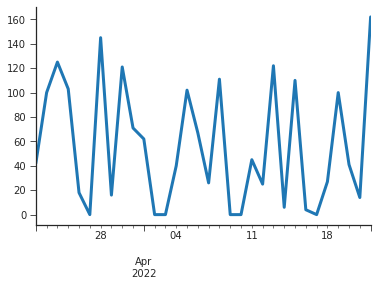

In [36]:
df.loc['2022-03-22':'2022-04-22','2022-04-23'].plot()


In [37]:
mts.modified_z_score( df.loc['2022-03-22':'2022-04-21','2022-04-23'], df.loc['2022-04-22','2022-04-23'])

1.9905975609756095

In [38]:
# ax.scatter(x= df.index[i], y=df.iloc[i, i+1], color="yellow", alpha=.3, s=300, marker='o')
ax.plot([df.index[i-window],df.index[i-window]], [0, 300])
ax.plot([df.index[i-window],df.index[i]], [0, 0])
ax.plot([df.index[i-window],df.index[i]], [300, 300])

plt.savefig(path.format(region=REGION, metric='nrcs_detail'),  bbox_inches="tight")

## Heat Map of intersection

In [39]:
nrcs_array = mts.nrcs_in_releases(X)

In [40]:
nrcs_df = pd.DataFrame(nrcs_array, index= df.index, columns=df.columns)

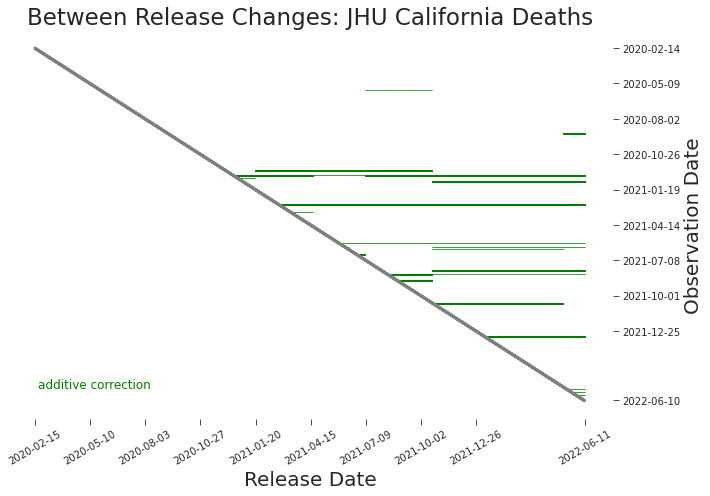

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Between Release Changes: JHU California Deaths'}, xlabel='Release Date', ylabel='Observation Date'>,
 {'high_key_val': 'Within-Release NRC',
  'title': 'Between Release Changes',
  'data_title': 'JHU California Deaths',
  'x_label': 'Release Date',
  'y_label': 'Observation Date',
  'y_scale': 'linear',
  'file_name': 'JHU_California_Deaths__Between_Release_Changes',
  'observation_dates': DatetimeIndex(['2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
                 '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
                 '2020-02-22', '2020-02-23',
                 ...
                 '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
                 '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
                 '2022-06-09', '2022-06-10'],
                dtype='datetime64[ns]', length=848, freq='D'),
  'release_dates': DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17',

In [41]:
# refer to original heat map within release changes
# heat map of nrcs

vs.plot_staircase(
    nrcs_df,
    data_title,
    heatmap=False,
    missing=False,
    high_key_val="Within-Release NRC"
)

In [42]:
mrs_df = pd.DataFrame(False, index=df.index, columns=df.columns)

In [43]:
for mr in mrs:
    mrs_df.loc[:mr, mr] = True

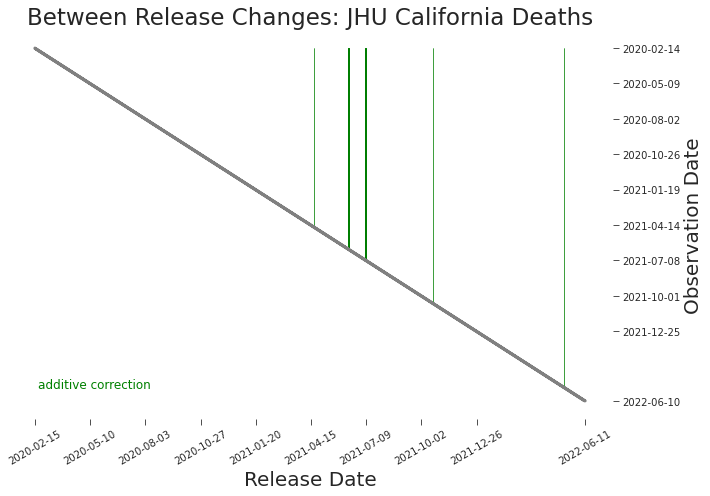

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Between Release Changes: JHU California Deaths'}, xlabel='Release Date', ylabel='Observation Date'>,
 {'title': 'Between Release Changes',
  'data_title': 'JHU California Deaths',
  'x_label': 'Release Date',
  'y_label': 'Observation Date',
  'y_scale': 'linear',
  'file_name': 'JHU_California_Deaths__Between_Release_Changes',
  'observation_dates': DatetimeIndex(['2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
                 '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
                 '2020-02-22', '2020-02-23',
                 ...
                 '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
                 '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
                 '2022-06-09', '2022-06-10'],
                dtype='datetime64[ns]', length=848, freq='D'),
  'release_dates': DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
                 '2020-02

In [44]:
vs.plot_staircase(
    mrs_df,
    data_title,
    heatmap=False,
    missing=False
)

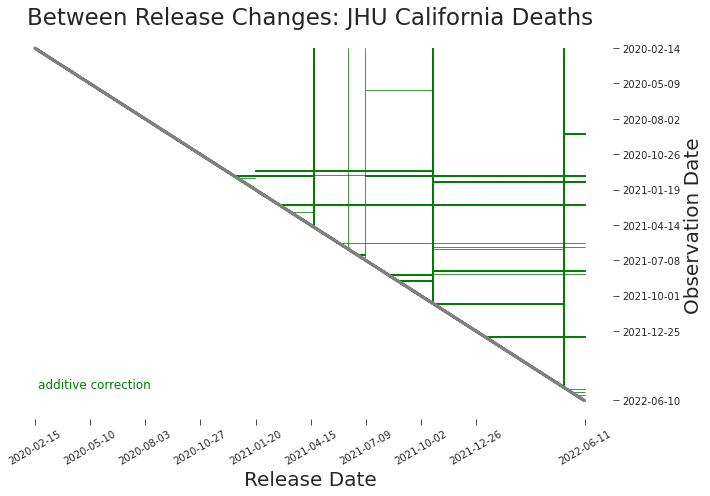

(<Figure size 720x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Between Release Changes: JHU California Deaths'}, xlabel='Release Date', ylabel='Observation Date'>,
 {'title': 'Between Release Changes',
  'data_title': 'JHU California Deaths',
  'x_label': 'Release Date',
  'y_label': 'Observation Date',
  'y_scale': 'linear',
  'file_name': 'JHU_California_Deaths__Between_Release_Changes',
  'observation_dates': DatetimeIndex(['2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
                 '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
                 '2020-02-22', '2020-02-23',
                 ...
                 '2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04',
                 '2022-06-05', '2022-06-06', '2022-06-07', '2022-06-08',
                 '2022-06-09', '2022-06-10'],
                dtype='datetime64[ns]', length=848, freq='D'),
  'release_dates': DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
                 '2020-02

In [45]:
both_df = pd.DataFrame(nrcs_array, index=df.index, columns=df.columns)
for mr in mrs:
    both_df.loc[:mr, mr] = True


vs.plot_staircase(
    both_df,
    data_title,
    heatmap=False,
    missing=False
)

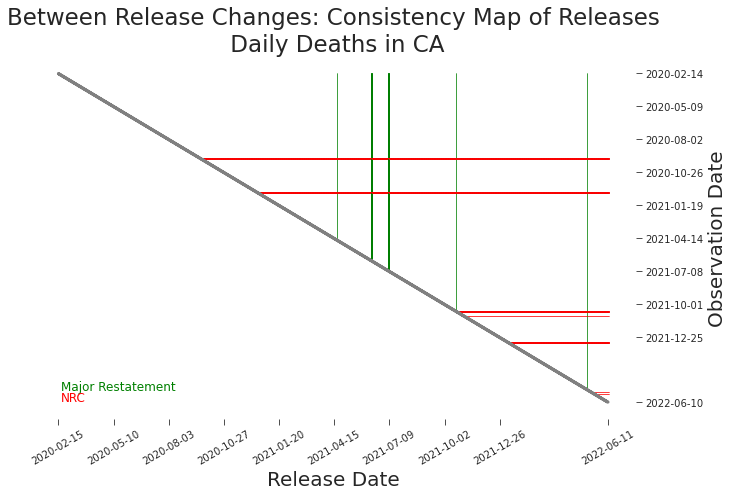

Text(0.5, 0.98, '')

In [46]:
both_df = pd.DataFrame(False, index=df.index, columns=df.columns)
for mr in mrs:
    both_df.loc[:mr, mr] = 1

for nrc in nrcs:
    both_df.iloc[nrc[0], nrc[0]:] = -1


plt, ax, _ = vs.plot_staircase(
    both_df,
    f'Consistency Map of Releases\n Daily Deaths in CA',
    heatmap=False,
    missing=False,
    high_val_key = "Major Restatement",
    low_val_key = "NRC"
)

ax.set_title("Consistency\nBetween Release and Within Release Heat Map\nDaily Deaths in CA")
plt.suptitle("")

In [47]:
plt.savefig(path.format(region=REGION, metric='consistency'),  bbox_inches="tight")

In [48]:
def get_over_time_release_history(releases, func, cols, **kwargs):
    
    vals = []

    for i in range(1, releases.shape[0]):

        vals.append([func(releases[:i, :i+1], i, **kwargs)])

    df = pd.DataFrame(vals, index=cols)

    return df

def get_over_time_release(releases, func, cols, **kwargs):
    
    vals = []

    for i in range(1, releases.shape[0]):

        vals.append([func(releases[:i, i], i, **kwargs)])

    df = pd.DataFrame(vals, index=cols)

    return df

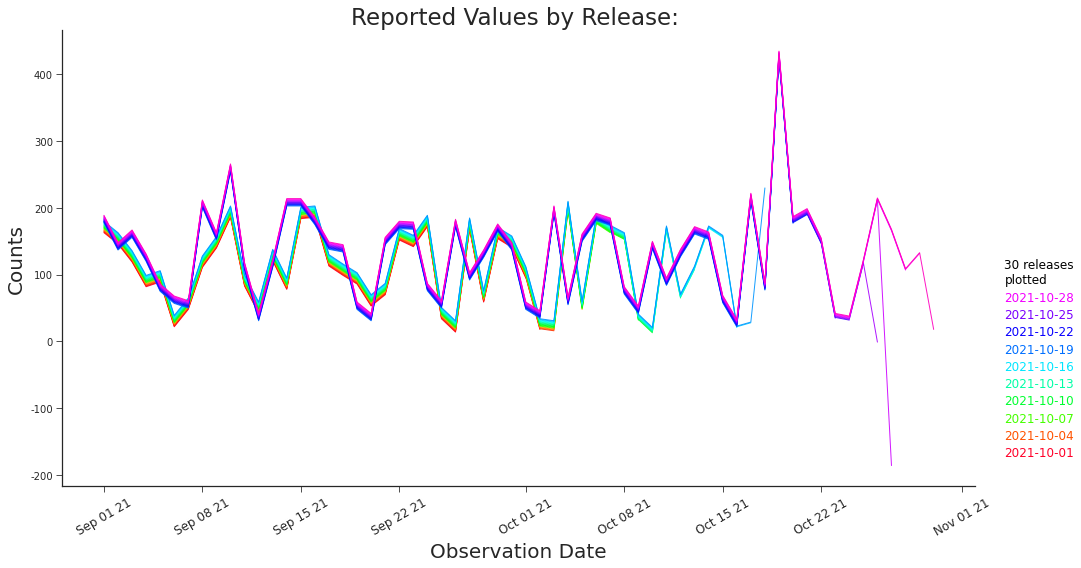

In [49]:
date = '2021-10-19'

plt, ax, __ = vs.plot_multiple_releases(df.loc['2021-09-01':'2021-11-01', '2021-10-01': '2021-10-30'], data_title='', shift=1, figsize=(14,8))
plt.suptitle(f'Releases Before and After Major Restatement\nOccurring at Release {date}', size=20)
ax.set_title("")
plt.savefig(path.format(region=REGION, metric='multiple_releases'),  bbox_inches="tight")



# Completeness

In [50]:
plot_release_history_df = get_over_time_release_history(X, mts.measure_release_history_completeness, df.columns[1:])
plot_release_df = get_over_time_release(X, mts.measure_release_completeness, df.columns[1:])

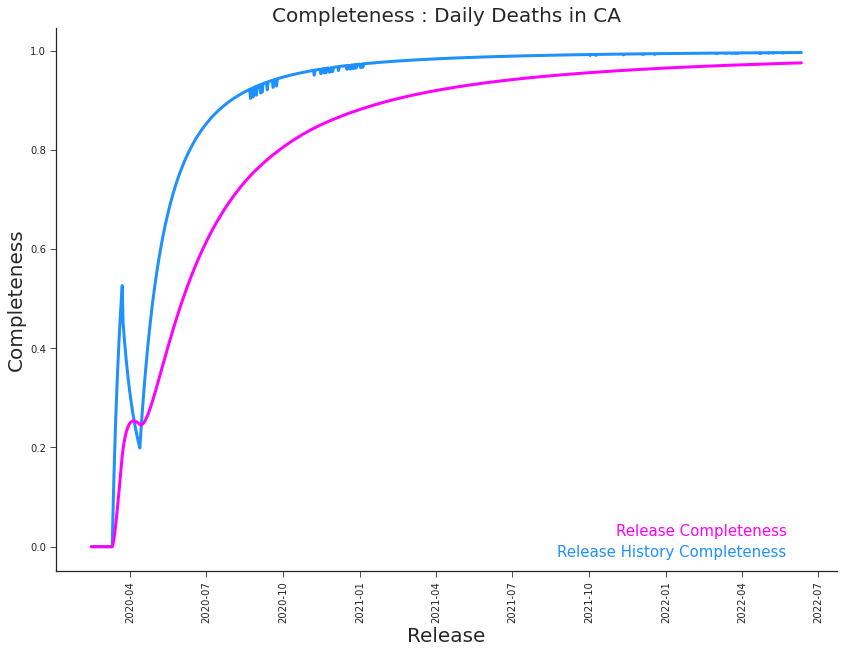

In [51]:
#  plot over time as release num increases
# plt, ax = plot_over_time(plot_release_df)

plt, ax, setup_dct =  vs.setup_plot(
    plot_release_history_df,
    data_title=f'Completeness\nDaily Deaths in CA',
    title="", x_label="Release", y_label="Completeness",
    nrows=1, ncols=1, y_scale="linear", figsize=(14, 10) #, sharex=False, sharey=False
)

ax.plot(plot_release_df, color='dodgerblue')
ax.plot(plot_release_history_df, color='magenta')
ax.set_title(label="Completeness : Daily Deaths in CA", fontsize=20)
plt.gcf().text(0.85, 0.175, f'Release Completeness',
    horizontalalignment='right',
    color="magenta",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.85, 0.145, f'Release History Completeness',
    horizontalalignment='right',
    color="dodgerblue",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.savefig(path.format(region=REGION, metric='completeness'),  bbox_inches="tight")


# Timeliness, Completeness, and Believability

In [52]:
vals = []
for i in range(X.shape[0]-8):
    vals.append([mts.estimate_filled_forward(X,  i, 7), mts.was_filled_forward(X[i,:], i, window= 7), X[i, i+1], X[i, i+8], X[i, i+1] ==0  ] )


In [53]:
df_ff =  pd.DataFrame(vals, index=df.index[:-8], columns=['est_ff', 'ff', 'first_released', 'plus_7', 'orig_0'])

In [54]:
ffs = df_ff[df_ff['orig_0']]

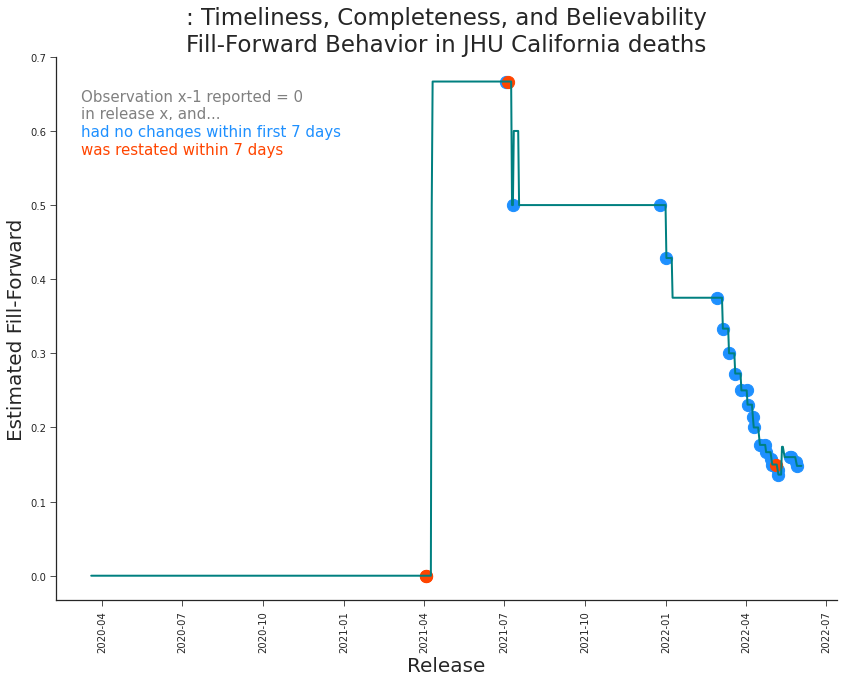

In [55]:
# plt, ax  = plot_over_time(plot_release_history_df_ff )
ffs_pos = ffs[ffs['ff']]
ffs_neg = ffs[ (ffs['ff'] == False)]


plt, ax, setup_dct =  vs.setup_plot(
    df_ff[['est_ff']], data_title=f'Timeliness, Completeness, and Believability\nFill-Forward Behavior in JHU {REGION} {COL}',
    title="", x_label="Release", y_label="Estimated Fill-Forward",
    nrows=1, ncols=1, y_scale="linear", figsize=(14, 10) #, sharex=False, sharey=False
)

ax.plot(df_ff['est_ff'], lw=2, color='teal')
ax.scatter(ffs_neg.index, df_ff.loc[ffs_neg.index, 'est_ff'], color='dodgerblue', s=150)
ax.scatter(ffs_pos.index, df_ff.loc[ffs_pos.index, 'est_ff'], color='orangered', s=150)
plt.gcf().text(0.15, 0.795, f'Observation x-1 reported = 0\nin release x, and...',
    horizontalalignment='left',
    color="grey",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.15, 0.77, f'had no changes within first 7 days',
    horizontalalignment='left',
    color="dodgerblue",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.15, 0.745, f'was restated within 7 days',
    horizontalalignment='left',
    color="orangered",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.savefig(path.format(region=REGION, metric='fillforward'),  bbox_inches="tight")


In [56]:
ffs_pos

,est_ff,ff,first_released,plus_7,orig_0
2021-04-03,0.000000,True,0.0,36.0,True
2021-04-04,0.000000,True,0.0,61.0,True
2021-07-05,0.666667,True,0.0,5.0,True
2022-05-05,0.150000,True,0.0,113.0,True


# Validity and Believability

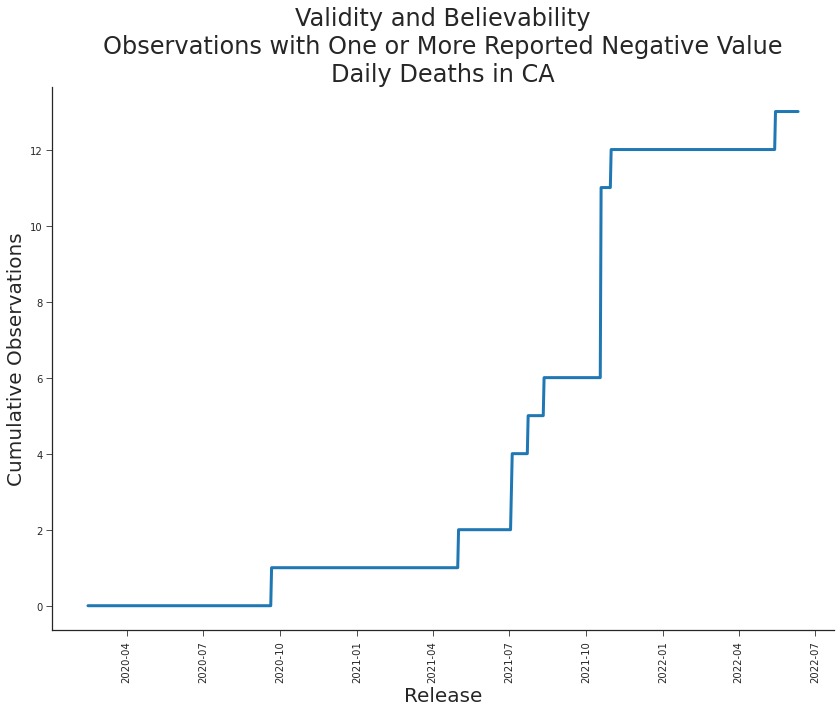

In [57]:
#  plot over time as release num increases

plot_release_history_df_vb = get_over_time_release_history(X, mts.measure_decreasing, df.columns[1:])

plt, ax, setup_dct =  vs.setup_plot(
    plot_release_history_df_vb ,
    data_title=f'Validity and Belivability\nCumulative Observations with a Report of Negative New Deaths\nDaily Deaths in CA',
    title="", x_label="Release", y_label="Cumulative Observations",
    nrows=1, ncols=1, y_scale="linear", figsize=(14, 10) #, sharex=False, sharey=False
)

ax.set_title("Validity and Believability\nObservations with One or More Reported Negative Value\nDaily Deaths in CA")

ax.plot(plot_release_history_df_vb)
plt.savefig(path.format(region=REGION, metric='num_decreasing'),  bbox_inches="tight")

# Believability

/Users/kerstin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kerstin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


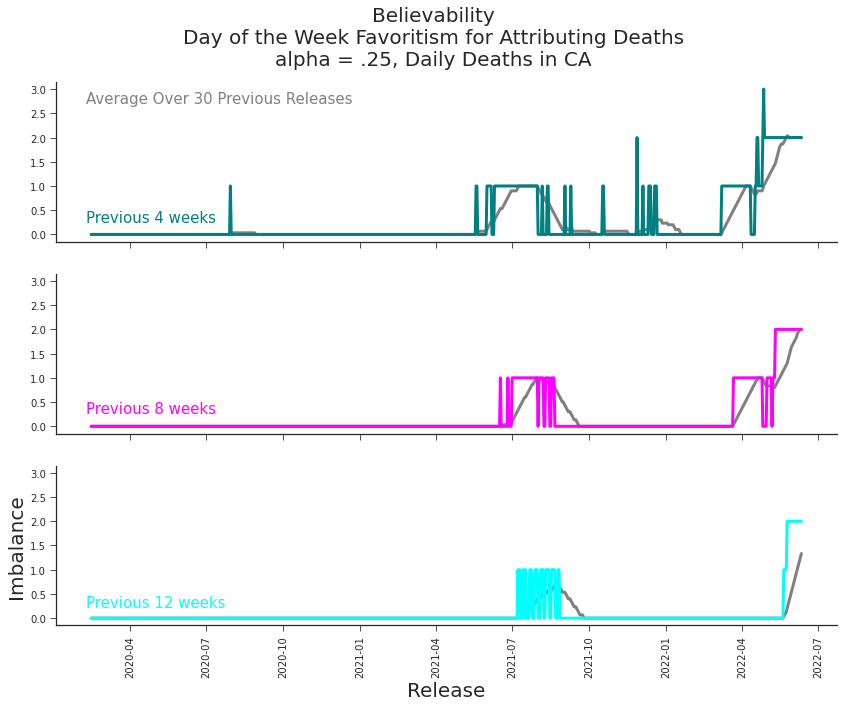

In [58]:
#  plot over time as release num increases
# measure_weekliness(releases, release_num, num_weeks=7, alpha = .33)

plot_release_history_df_b_8 = get_over_time_release(X, mts.measure_weekliness, df.columns[1:], num_weeks = 8, alpha=.25)
plot_release_history_df_b_8_rolling  = plot_release_history_df_b_8.rolling(30, min_periods=1).mean()
plot_release_history_df_b_4 = get_over_time_release(X, mts.measure_weekliness, df.columns[1:], num_weeks=4, alpha=.25)
plot_release_history_df_b_4_rolling  = plot_release_history_df_b_4.rolling(30, min_periods=1).mean()
plot_release_history_df_b_12 = get_over_time_release(X, mts.measure_weekliness, df.columns[1:], num_weeks=12, alpha=.25)
plot_release_history_df_b_12_rolling  = plot_release_history_df_b_12.rolling(30, min_periods=1).mean()

plt, axs, setup_dct =  vs.setup_plot(
    plot_release_history_df_b_8 ,
    data_title="",
    title="", x_label="Release", y_label="Imbalance",
    nrows=3, ncols=1, y_scale="linear", figsize=(14, 10) #, sharex=False, sharey=False
)
title = f'Believability\nDay of the Week Favoritism for Attributing Deaths\nalpha = .25, Daily Deaths in CA'
plt.suptitle(title, size=20, y=.985)
axs[0,0].plot(plot_release_history_df_b_4_rolling, color='grey' )
axs[1,0].plot(plot_release_history_df_b_8_rolling, "grey" )
axs[2,0].plot(plot_release_history_df_b_12_rolling, color='grey' )
axs[0,0].plot(plot_release_history_df_b_4, color='teal' )
axs[1,0].plot(plot_release_history_df_b_8, "magenta" )
axs[2,0].plot(plot_release_history_df_b_12, color='cyan' )

plt.gcf().text(0.155, 0.685, f'Previous 4 weeks',
    horizontalalignment='left',
    color="teal",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.155, 0.420, f'Previous 8 weeks ',
    horizontalalignment='left',
    color="magenta",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.155, 0.150, f'Previous 12 weeks',
    horizontalalignment='left',
    color="cyan",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))

plt.gcf().text(0.155, 0.85, f'Average Over 30 Previous Releases',
    horizontalalignment='left',
    color="grey",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))

plt.savefig(path.format(region=REGION, metric='weekliness'),  bbox_inches="tight")

In [59]:
plot_release_history_df_b_4_rolling.loc['2021-12-30',]

0    0.233333
Name: 2021-12-30 00:00:00, dtype: float64

# Example

In [60]:
date_of_training = '2021-12-30'
index_of_training = df.index.get_loc(date_of_training)
len_of_training = 90
len_of_preds = 7
num_divs = 5
offset=21

In [61]:
# vs.plot_multiple_releases(df.loc['2021-08-05': '2021-08-15', '2021-08-10': date_of_training], "")

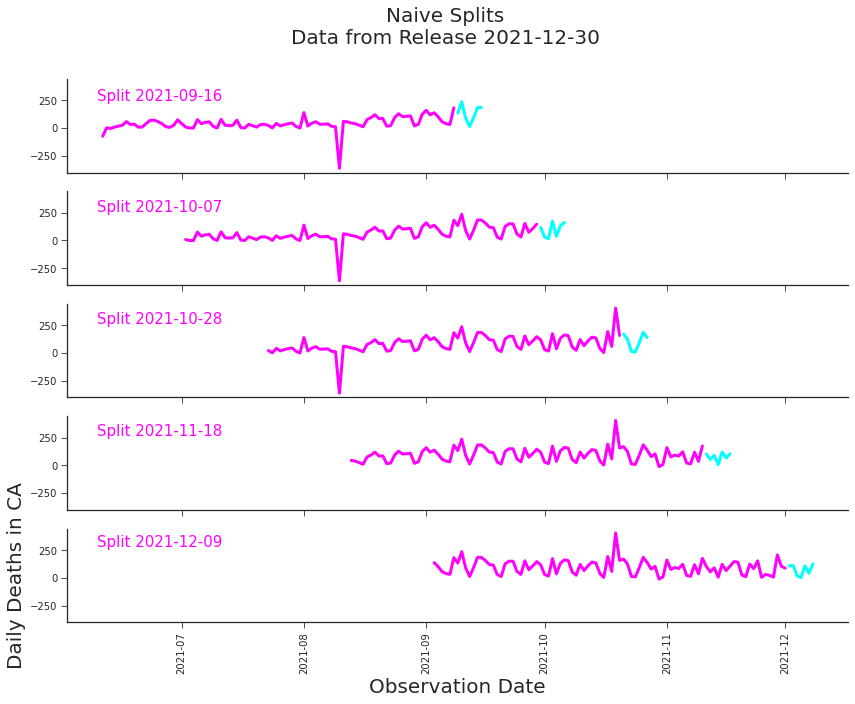

In [62]:
def get_train_test(index_of_training, naive = False, stable_release_index=None):
    """Assumes a columns == index"""
    end = index_of_training 
    mid = end - len_of_preds
    beg = mid - len_of_training
    if naive:
        training_df = df.iloc[ beg: mid, [stable_release_index]]
        testing_df = df.iloc[ mid:end, [stable_release_index]]
    else:
        training_df = df.iloc[ beg: mid, [mid]]
        testing_df = df.iloc[ mid:end, [end]]
    return training_df, testing_df, (beg, mid, end)

train, test, __ = get_train_test(index_of_training, naive=True,stable_release_index=index_of_training + len_of_preds)

plt, axs, setup_dct =  vs.setup_plot(
    train ,
    data_title="",
    title="", x_label="Observation Date", y_label=f'Daily Deaths in CA',
    nrows=num_divs, ncols=1, y_scale="linear", figsize=(14, 10), sharex=True, sharey=True
)

for i in range(num_divs):
    div_loc = index_of_training - (num_divs -i)*offset
    train, test, __ = get_train_test(div_loc, naive=True, stable_release_index=index_of_training + len_of_preds)
    axs[i,0].plot( train, color='magenta')
    axs[i,0].plot( test, color='cyan')
    mid_date = df.columns[div_loc].strftime('%Y-%m-%d')
    plt.gcf().text(0.155, 0.85-i*.155, f'Split {mid_date}',
        horizontalalignment='left',
        color="magenta",
        fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))

plt.suptitle(f'Naive Splits\nData from Release {date_of_training}', size=20)
plt.savefig(path.format(region=REGION, metric='training_splits_naive'),  bbox_inches="tight")


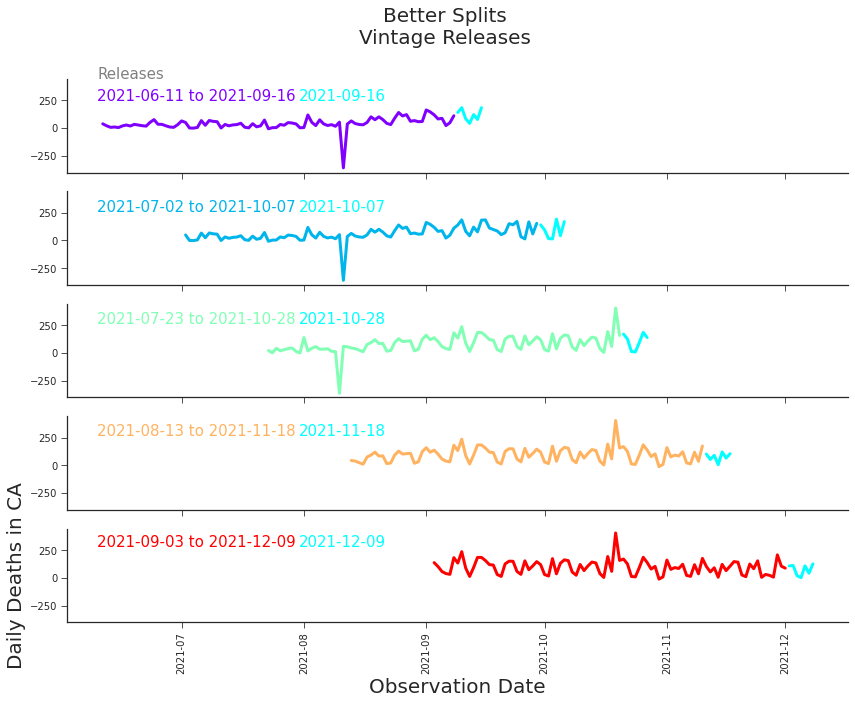

In [63]:
train, test, __ = get_train_test(index_of_training, naive=True,stable_release_index=index_of_training)

plt, axs, setup_dct =  vs.setup_plot(
    train ,
    data_title="",
    title="", x_label="Observation Date", y_label=f'Daily Deaths in CA',
    nrows=num_divs, ncols=1, y_scale="linear", figsize=(14, 10), sharex=True, sharey=True
)
colors = plt.cm.rainbow(np.linspace(0, 1, num_divs))

for i in range(num_divs):
    div_loc = index_of_training - (num_divs -i)*offset
    train, test, pts =  get_train_test(div_loc)
    axs[i,0].plot( train, color=colors[i])
    axs[i,0].plot( test, color='cyan')
    
    beg_date = df.columns[pts[0]].strftime('%Y-%m-%d')
    mid_date = df.columns[div_loc].strftime('%Y-%m-%d')
    end_date = df.columns[pts[2]].strftime('%Y-%m-%d')
    plt.gcf().text(0.155, 0.85-i*.155, f'{beg_date} to {mid_date}',
        horizontalalignment='left',
        color=colors[i],
        fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
    plt.gcf().text(0.355, 0.85-i*.155, f'{end_date}',
        horizontalalignment='left',
        color='cyan',
        fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
    
plt.gcf().text(0.155, 0.88, f'Releases',
    horizontalalignment='left',
    color='grey',
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))

plt.suptitle(f'Better Splits\nVintage Releases', size=20)
plt.savefig(path.format(region=REGION, metric='training_splits_better'),  bbox_inches="tight")


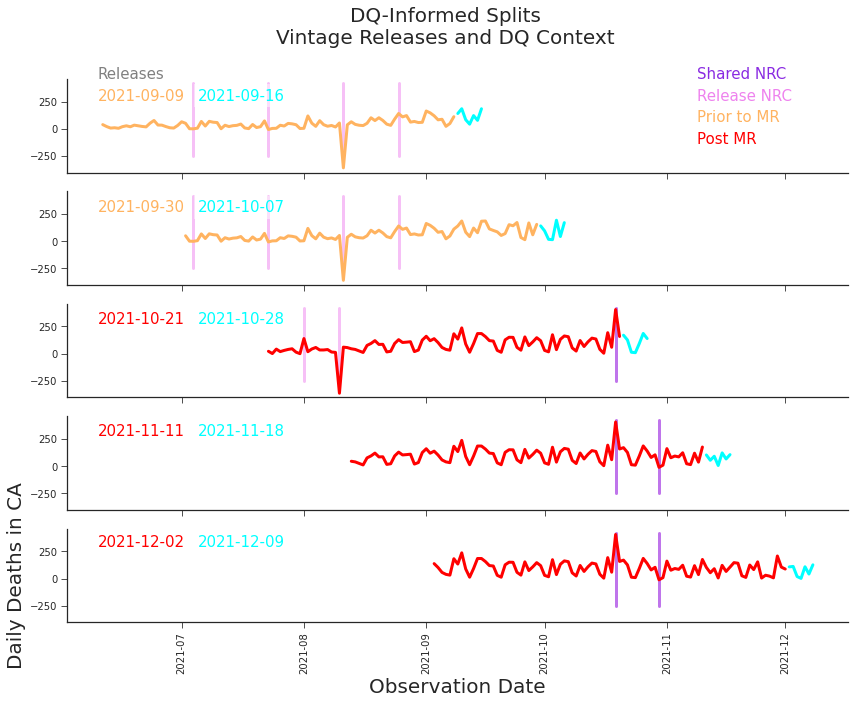

In [73]:
train, test, __ = get_train_test(index_of_training, naive=True,stable_release_index=index_of_training)

plt, axs, setup_dct =  vs.setup_plot(
    train ,
    data_title="",
    title="", x_label="Observation Date", y_label=f'Daily Deaths in CA',
    nrows=num_divs, ncols=1, y_scale="linear", figsize=(14, 10), sharex=True, sharey=True
)

# get NRCS as detected at this time
window = 30
alpha= 4

mrs_ind = [df.index.get_loc(i) for i in mrs] # is not sensitive to subsequent releases
shared = mts.shared_nrcs(X[:index_of_training, :index_of_training], window=window, alpha=alpha, neg=True)
nrcs = [(i, each) for i, each in enumerate(shared) if each ] # shared nrcs may disapear after subsequent releases
nrcs_ind = [i for i,j in nrcs]

mr_colors = []
colors = plt.cm.rainbow(np.linspace(0, 1, len(mrs_ind)))


for i in range(num_divs):


    div_loc = index_of_training - (num_divs -i)*offset
    train, test, pts = get_train_test(div_loc)
    beg, mid, end = pts
    
    j = 0
    while j < len(mrs_ind) and mrs_ind[j] < mid:
        j += 1

    color = colors[j]
    
    mr_colors.append(j)

    release_nrcs = mts.nrcs_in_release(X[:mid, mid], release_num=mid, window=window, alpha=alpha, neg=True)
    release_nrcs = [ind for ind, val in release_nrcs if val and ind > beg]
    
    for j in release_nrcs:
        point = df.index[j]
        axs[i,0].plot([point, point],[-250,420], color='violet', alpha=.5)

    for j in nrcs_ind:
        if j >= beg and j <= end:
            point = df.index[j]
            axs[i,0].plot([point, point],[-250,420], color='blueviolet', alpha=.5)
    
    axs[i,0].plot( train, color=color)
    axs[i,0].plot( test, color='cyan')

    beg_date = df.columns[beg].strftime('%Y-%m-%d')
    mid_date = df.columns[mid].strftime('%Y-%m-%d')
    end_date = df.columns[end].strftime('%Y-%m-%d')

    plt.gcf().text(0.155, 0.85-i*.155, f'{mid_date}',
        horizontalalignment='left',
        color=color,
        fontsize=15, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))
    plt.gcf().text(0.255, 0.85-i*.155, f'{end_date}',
        horizontalalignment='left',
        color='cyan',
        fontsize=15, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))
    
plt.gcf().text(0.155, 0.88, f'Releases',
    horizontalalignment='left',
    color='grey',
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))


plt.gcf().text(0.75, 0.88, f'Shared NRC',
    horizontalalignment='left',
    color='blueviolet',
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.75, 0.85, f'Release NRC',
    horizontalalignment='left',
    color='violet',
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))


mr_colors = sorted(list(set(mr_colors)))
plt.gcf().text(0.75, 0.82, f'Prior to MR',
    horizontalalignment='left',
    color=colors[mr_colors[0]],
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.75, 0.79, f'Post MR',
    horizontalalignment='left',
    color=colors[mr_colors[1]],
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))

plt.suptitle(f'DQ-Informed Splits\nVintage Releases and DQ Context', size=20)
plt.savefig(path.format(region=REGION, metric='training_splits_best'),  bbox_inches="tight")


In [74]:
last_date = '2021-10-30'
index_last_date = df.columns.get_loc(last_date)
index_of_training - index_last_date

len_of_training = 30
len_of_preds = 7
num_divs = 5
offset=4

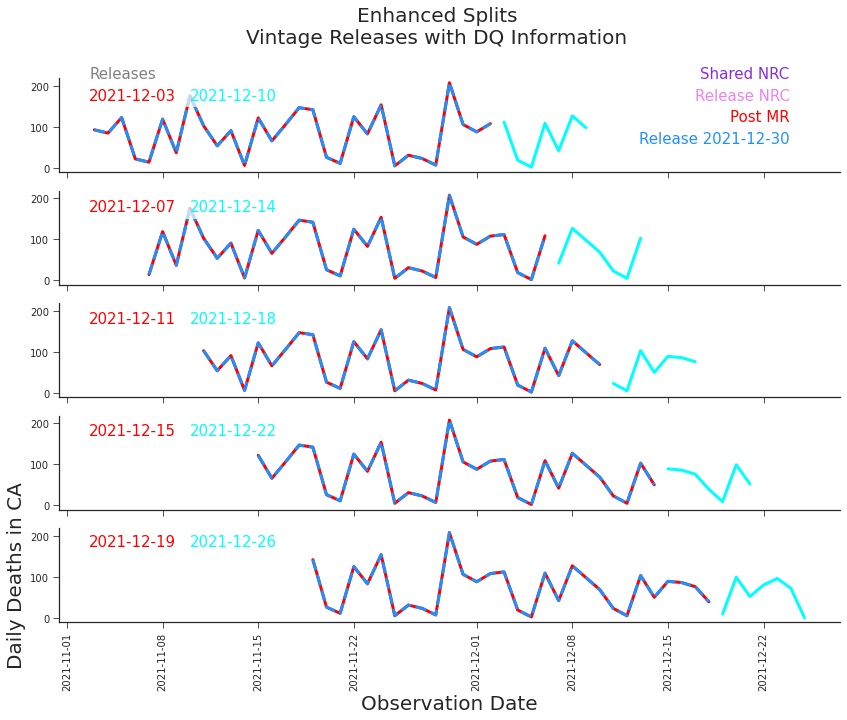

In [75]:

train, test, __ = get_train_test(index_of_training, naive=True,stable_release_index=index_of_training)

plt, axs, setup_dct =  vs.setup_plot(
    train ,
    data_title="",
    title="", x_label="Observation Date", y_label=f'Daily Deaths in CA',
    nrows=num_divs, ncols=1, y_scale="linear", figsize=(14, 10), sharex=True, sharey=True
)

# !!! Get NRCS as detected at this time!
window = 30
alpha= 4

mrs_ind = [df.index.get_loc(i) for i in mrs] # is not sensitive to subsequent releases
shared = mts.shared_nrcs(X[:index_of_training, :index_of_training], window=window, alpha=alpha, neg=True)
nrcs = [(i, each) for i, each in enumerate(shared) if each ] # shared nrcs may disapear after subsequent releases
nrcs_ind = [i for i,j in nrcs]
colors = plt.cm.rainbow(np.linspace(0, 1, len(mrs_ind)))

mr_colors = []


for i in range(num_divs):


    div_loc = index_of_training - (num_divs -i)*offset
    train, test, pts = get_train_test(div_loc)
    train_n, test_n, pts_n = get_train_test( div_loc, naive=True, stable_release_index=index_of_training)
    beg, mid, end = pts
    
    j = 0
    while j < len(mrs_ind) and mrs_ind[j] < mid:
        j += 1

    color = colors[j]
    
    mr_colors.append(j)

    release_nrcs = mts.nrcs_in_release(X[:mid, mid], release_num=mid, window=window, alpha=alpha, neg=True)
    release_nrcs = [ind for ind, val in release_nrcs if val and ind > beg]
    
    for j in release_nrcs:
        point = df.index[j]
        axs[i,0].plot([point, point],[0,420], color='violet', alpha=.5)

    for j in nrcs_ind:
        if j >= beg and j <= end:
            point = df.index[j]
            axs[i,0].plot([point, point],[0,420], color='blueviolet', alpha=.5)
    
    axs[i,0].plot( train, color=color)
    axs[i,0].plot( train, '--', color='dodgerblue')
    axs[i,0].plot( test, color='cyan')

    beg_date = df.columns[beg].strftime('%Y-%m-%d')
    mid_date = df.columns[mid].strftime('%Y-%m-%d')
    end_date = df.columns[end].strftime('%Y-%m-%d')
    release_date = df.columns[index_of_training].strftime('%Y-%m-%d')

    plt.gcf().text(0.155, 0.85-i*.155, f'{mid_date}',
        horizontalalignment='left',
        color=color,
        fontsize=15, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))
    plt.gcf().text(0.255, 0.85-i*.155, f'{end_date}',
        horizontalalignment='left',
        color='cyan',
        fontsize=15, bbox=dict(facecolor='white', edgecolor='none', alpha=.7))
    
plt.gcf().text(0.155, 0.88, f'Releases',
    horizontalalignment='left',
    color='grey',
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.85, 0.88, f'Shared NRC',
    horizontalalignment='right',
    color='blueviolet',
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.85, 0.85, f'Release NRC',
    horizontalalignment='right',
    color='violet',
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))
plt.gcf().text(0.85, 0.82, f'Post MR',
    horizontalalignment='right',
    color=colors[mr_colors[0]],
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none'))

plt.gcf().text(0.85, 0.79, f'Release {release_date}',
    horizontalalignment='right',
    color="dodgerblue",
    fontsize=15, bbox=dict(facecolor='white', edgecolor='none', alpha=.5))

plt.suptitle(f'Enhanced Splits\nVintage Releases with DQ Information', size=20)
plt.savefig(path.format(region=REGION, metric='training_splits_adjusted'),  bbox_inches="tight")

## Metrics

In [76]:
dt = '2021-12-30'
ind = df.index.get_loc(dt)
dt_dt = df.index[ind]

In [82]:
ind_nrc = mts.most_recent_shared_nrc(X[:ind, :ind], alpha=alpha, beta=beta, neg=True)
date_nrc = df.index[ind_nrc]
date_nrc_str = date_nrc.strftime('%Y-%m-%d')

nrc_measure = (ind  - df.index.get_loc(date_nrc_str) ) / ind 

In [83]:
date_mr = max([mr for mr in mrs if mr <= dt_dt])
date_mr_str = date_mr.strftime('%Y-%m-%d')

mr_measure = (ind  + 1 - df.index.get_loc(date_mr_str) ) / ind


In [84]:


dct = OrderedDict()

dct['Estimated Accuracy, k = 30'] = assessed_df.loc[dt,'30']
dct['Consistency Major Restatement'] = mr_measure
dct['Consistency Most Recent MR'] = date_mr_str
dct['Consistency NRC'] =  nrc_measure 
dct['Consistency Most Recent NRC'] = date_nrc_str
dct['Completeness of Release'] = plot_release_df.loc[date, 0]
dct['Completeness of Dataset'] = plot_release_history_df.loc[date, 0]
dct['Timeliness, Completeness, and Believability'] = df_ff.loc[dt, 'est_ff']
dct['Validity and Believability'] =  plot_release_history_df_vb.loc[dt,0]
dct['Believability of Release'] =  plot_release_history_df_b_4.loc[dt,0]
dct['Believability of Dataset'] =  plot_release_history_df_b_4_rolling.loc[dt,0]
dct['Measured Accuracy'] =  accuracy_rh_df.loc[dt,'30']

index = dct.keys()

daily_metrics = pd.DataFrame({dt: dct})
daily_metrics = daily_metrics.reindex(index)


In [85]:
vals = []
for val in daily_metrics[dt]:

    if isinstance(val, float):
        vals.append("{:,.3f}".format(val))

    else:
        vals.append(val)


In [86]:
daily_metrics[dt] = vals

In [87]:
vs.df_to_latex(daily_metrics.iloc[:-1,:], f'{REGION} {COL} {dt}, Measured in Real-Time')

In [88]:
vs.df_to_latex(daily_metrics.iloc[-1,:], f'{REGION} {COL} {dt}')

# DO NOT ADD BELOW TO SCRIPT

In [90]:
daily_metrics

,2021-12-30
"Estimated Accuracy, k = 30",-0.150
Consistency Major Restatement,0.107
Consistency Most Recent MR,2021-10-19
Consistency NRC,0.089
Consistency Most Recent NRC,2021-10-30
Completeness of Release,0.992
Completeness of Dataset,0.958
"Timeliness, Completeness, and Believability",0.500
Validity and Believability,12
Believability of Release,0


In [84]:
dfs_dict['California']

,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,...,2022-06-02,2022-06-03,2022-06-04,2022-06-05,2022-06-06,2022-06-07,2022-06-08,2022-06-09,2022-06-10,2022-06-11
2020-02-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,60.0,60.0,60.0,60.0,60.0
2022-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19.0,19.0,19.0,19.0
2022-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,14.0
2022-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,88.0


In [89]:
import jupyckage.jupyckage as jp 
import shutil

to_latex_folder = "../latex/code/notebooks/"

notebook_name = "Metrics_TimeSeries_CA_Deaths_JHU"

jp.notebook_to_package(f'{notebook_name}.ipynb')

shutil.copy( f'notebooks/src/{notebook_name}/{notebook_name}.py', f'{to_latex_folder}{notebook_name}.py')

'../latex/code/notebooks/Metrics_TimeSeries_CA_Deaths_JHU.py'